In [1]:
import numpy as np
import pickle

import multiprocessing
from joblib import Parallel, delayed

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist, pdist

from scipy.stats import mode

import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_context('talk')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
matplotlib.rcParams['lines.linewidth'] = 5

In [2]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

def centroids(X,label=None):
    if label is not None:
        cLabel,cCounts = np.unique(label,return_counts=True)
        cLabel = cLabel[cCounts > 1]
        c = np.zeros((len(cLabel), X.shape[1]))
        for i,l in enumerate(cLabel):
            c[i,:] = bipolarize(np.sum(X[label==l],axis=0))
    else:
        c = bipolarize(np.sum(X,axis=0)).reshape(1,-1)
        cLabel = [0]
    return cLabel, c.astype('int')

def classify(v,am,metric):
    d = cdist(v,am,metric)
    label = np.argmin(d,axis=1)
    return label

In [3]:
np.set_printoptions(precision=4)

### loading data
# select dataset and encoding type
dataName = 'allHV.npz'

allHV = np.load(dataName)

# extract data and labels based on gesture, trial, and position
hv = allHV['hvRel']
hvAcc = allHV['hvRelAcc']
gestLabel = allHV['gestLabel']
posLabel = allHV['posLabel']
trialLabel = allHV['trialLabel']

combGP, groupGP = np.unique(np.column_stack((gestLabel,posLabel)),axis=0,return_inverse=True)
combPG, groupPG = np.unique(np.column_stack((posLabel,gestLabel)),axis=0,return_inverse=True)
combGPT, groupGPT = np.unique(np.column_stack((gestLabel,posLabel,trialLabel)),axis=0,return_inverse=True)

# get list of unique values for each label
gestures = np.unique(gestLabel)
positions = np.unique(posLabel)
trials = np.unique(trialLabel)

numGestures = len(gestures)
numPositions = len(positions)
numTrials = len(trials)

# get data size info
D = hv.shape[1] # hypervector dimension
numHV = 80 # number of examples per trial

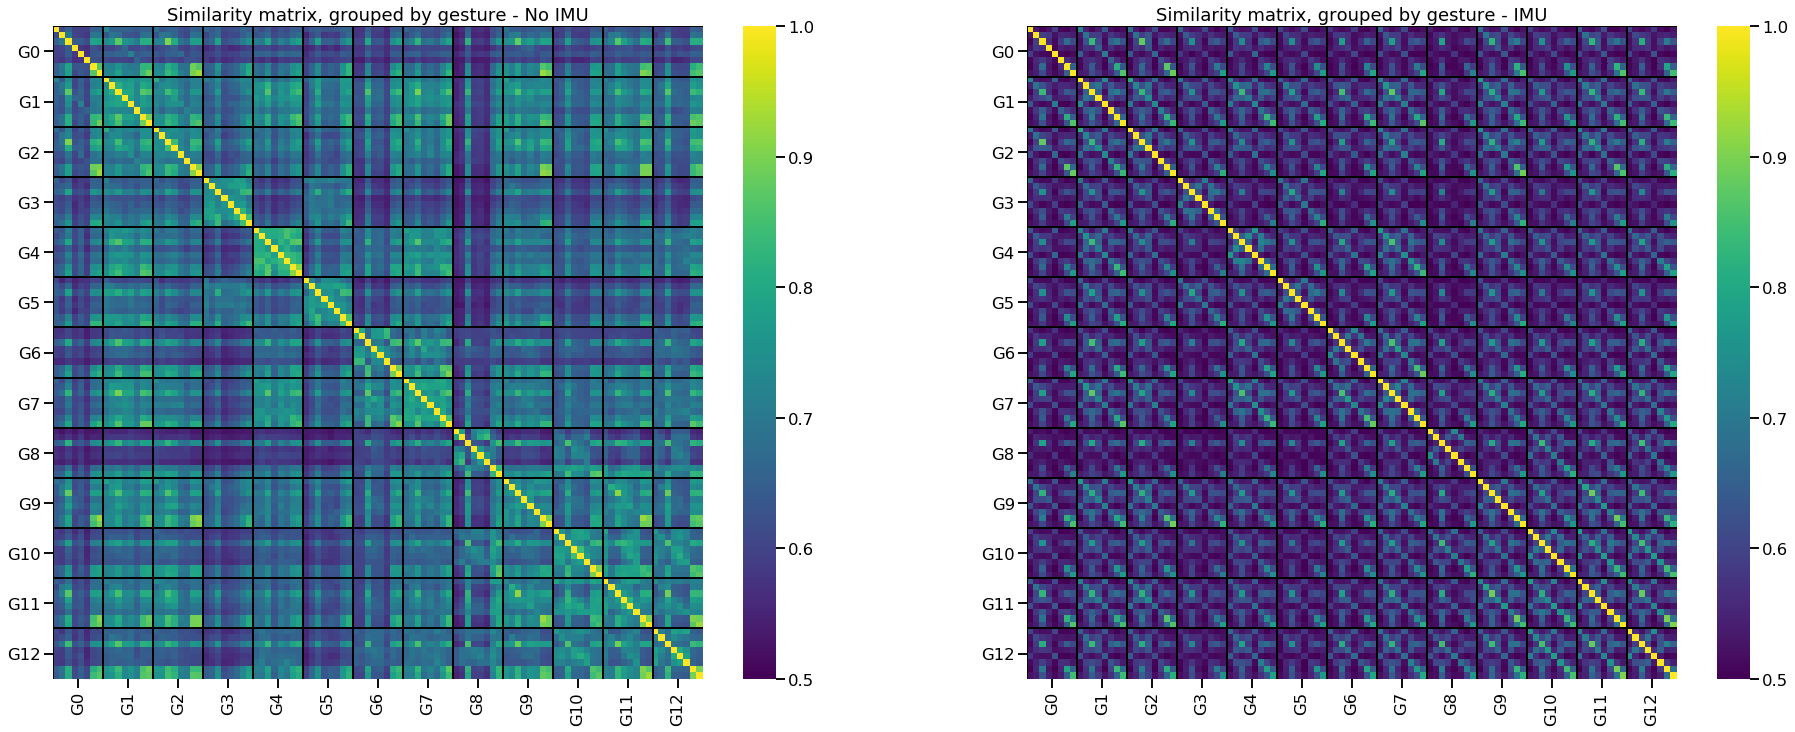

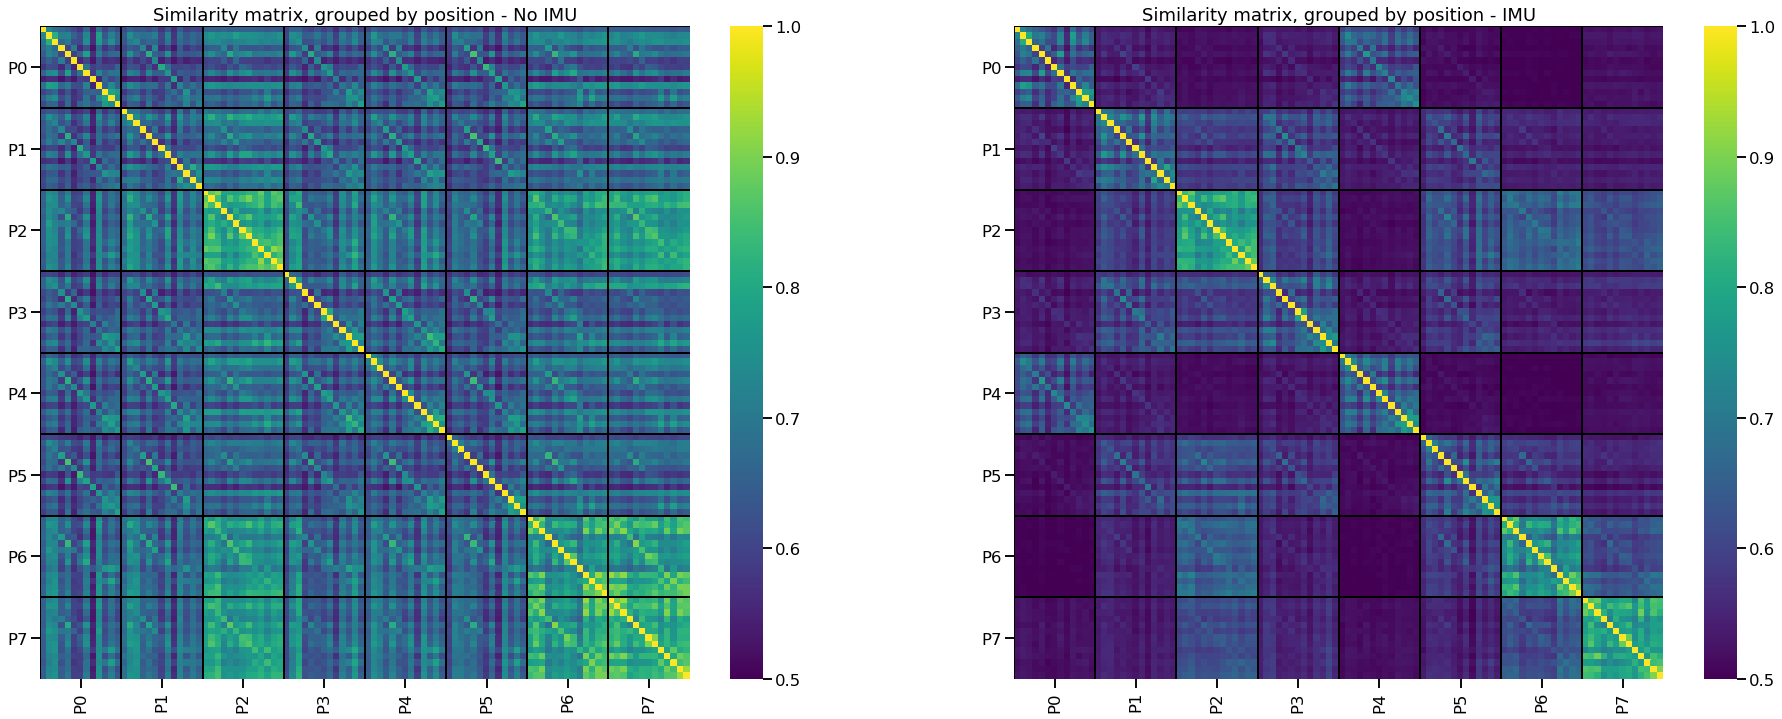

In [243]:
f,ax = plt.subplots(1,2,figsize=(32,12))

allCentroids = centroids(hv,label=groupGP)
allCentroidDist = 1 - cdist(allCentroids[1],allCentroids[1],'hamming')

sns.heatmap(allCentroidDist,vmin=0.5,vmax=1,cmap='viridis',ax=ax[0])
ax[0].hlines(np.arange(numGestures)*numPositions, *ax[0].get_xlim(),linewidth=2)
ax[0].vlines(np.arange(numGestures)*numPositions, *ax[0].get_xlim(),linewidth=2)
ax[0].set_xticks(np.arange(numGestures)*numPositions + 4)
ax[0].set_xticklabels(['G' + str(g) for g in gestures])
ax[0].set_yticks(np.arange(numGestures)*numPositions + 4)
ax[0].set_yticklabels(['G' + str(g) for g in gestures])
ax[0].set_title('Similarity matrix, grouped by gesture - No IMU')

allCentroids = centroids(hvAcc,label=groupGP)
allCentroidDist = 1 - cdist(allCentroids[1],allCentroids[1],'hamming')

sns.heatmap(allCentroidDist,vmin=0.5,vmax=1,cmap='viridis',ax=ax[1])
ax[1].hlines(np.arange(numGestures)*numPositions, *ax[1].get_xlim(),linewidth=2)
ax[1].vlines(np.arange(numGestures)*numPositions, *ax[1].get_xlim(),linewidth=2)
ax[1].set_xticks(np.arange(numGestures)*numPositions + 4)
ax[1].set_xticklabels(['G' + str(g) for g in gestures])
ax[1].set_yticks(np.arange(numGestures)*numPositions + 4)
ax[1].set_yticklabels(['G' + str(g) for g in gestures])
ax[1].set_title('Similarity matrix, grouped by gesture - IMU')

plt.show()


f,ax = plt.subplots(1,2,figsize=(32,12))

allCentroids = centroids(hv,label=groupPG)
allCentroidDist = 1 - cdist(allCentroids[1],allCentroids[1],'hamming')

sns.heatmap(allCentroidDist,vmin=0.5,vmax=1,cmap='viridis',ax=ax[0])
ax[0].hlines(np.arange(numPositions)*numGestures, *ax[0].get_xlim(),linewidth=2)
ax[0].vlines(np.arange(numPositions)*numGestures, *ax[0].get_xlim(),linewidth=2)
ax[0].set_xticks(np.arange(numPositions)*numGestures + 6.5)
ax[0].set_xticklabels(['P' + str(p) for p in positions])
ax[0].set_yticks(np.arange(numPositions)*numGestures + 6.5)
ax[0].set_yticklabels(['P' + str(p) for p in positions])
ax[0].set_title('Similarity matrix, grouped by position - No IMU')

allCentroids = centroids(hvAcc,label=groupPG)
allCentroidDist = 1 - cdist(allCentroids[1],allCentroids[1],'hamming')

sns.heatmap(allCentroidDist,vmin=0.5,vmax=1,cmap='viridis',ax=ax[1])
ax[1].hlines(np.arange(numPositions)*numGestures, *ax[1].get_xlim(),linewidth=2)
ax[1].vlines(np.arange(numPositions)*numGestures, *ax[1].get_xlim(),linewidth=2)
ax[1].set_xticks(np.arange(numPositions)*numGestures + 6.5)
ax[1].set_xticklabels(['P' + str(p) for p in positions])
ax[1].set_yticks(np.arange(numPositions)*numGestures + 6.5)
ax[1].set_yticklabels(['P' + str(p) for p in positions])
ax[1].set_title('Similarity matrix, grouped by position - IMU')

plt.show()

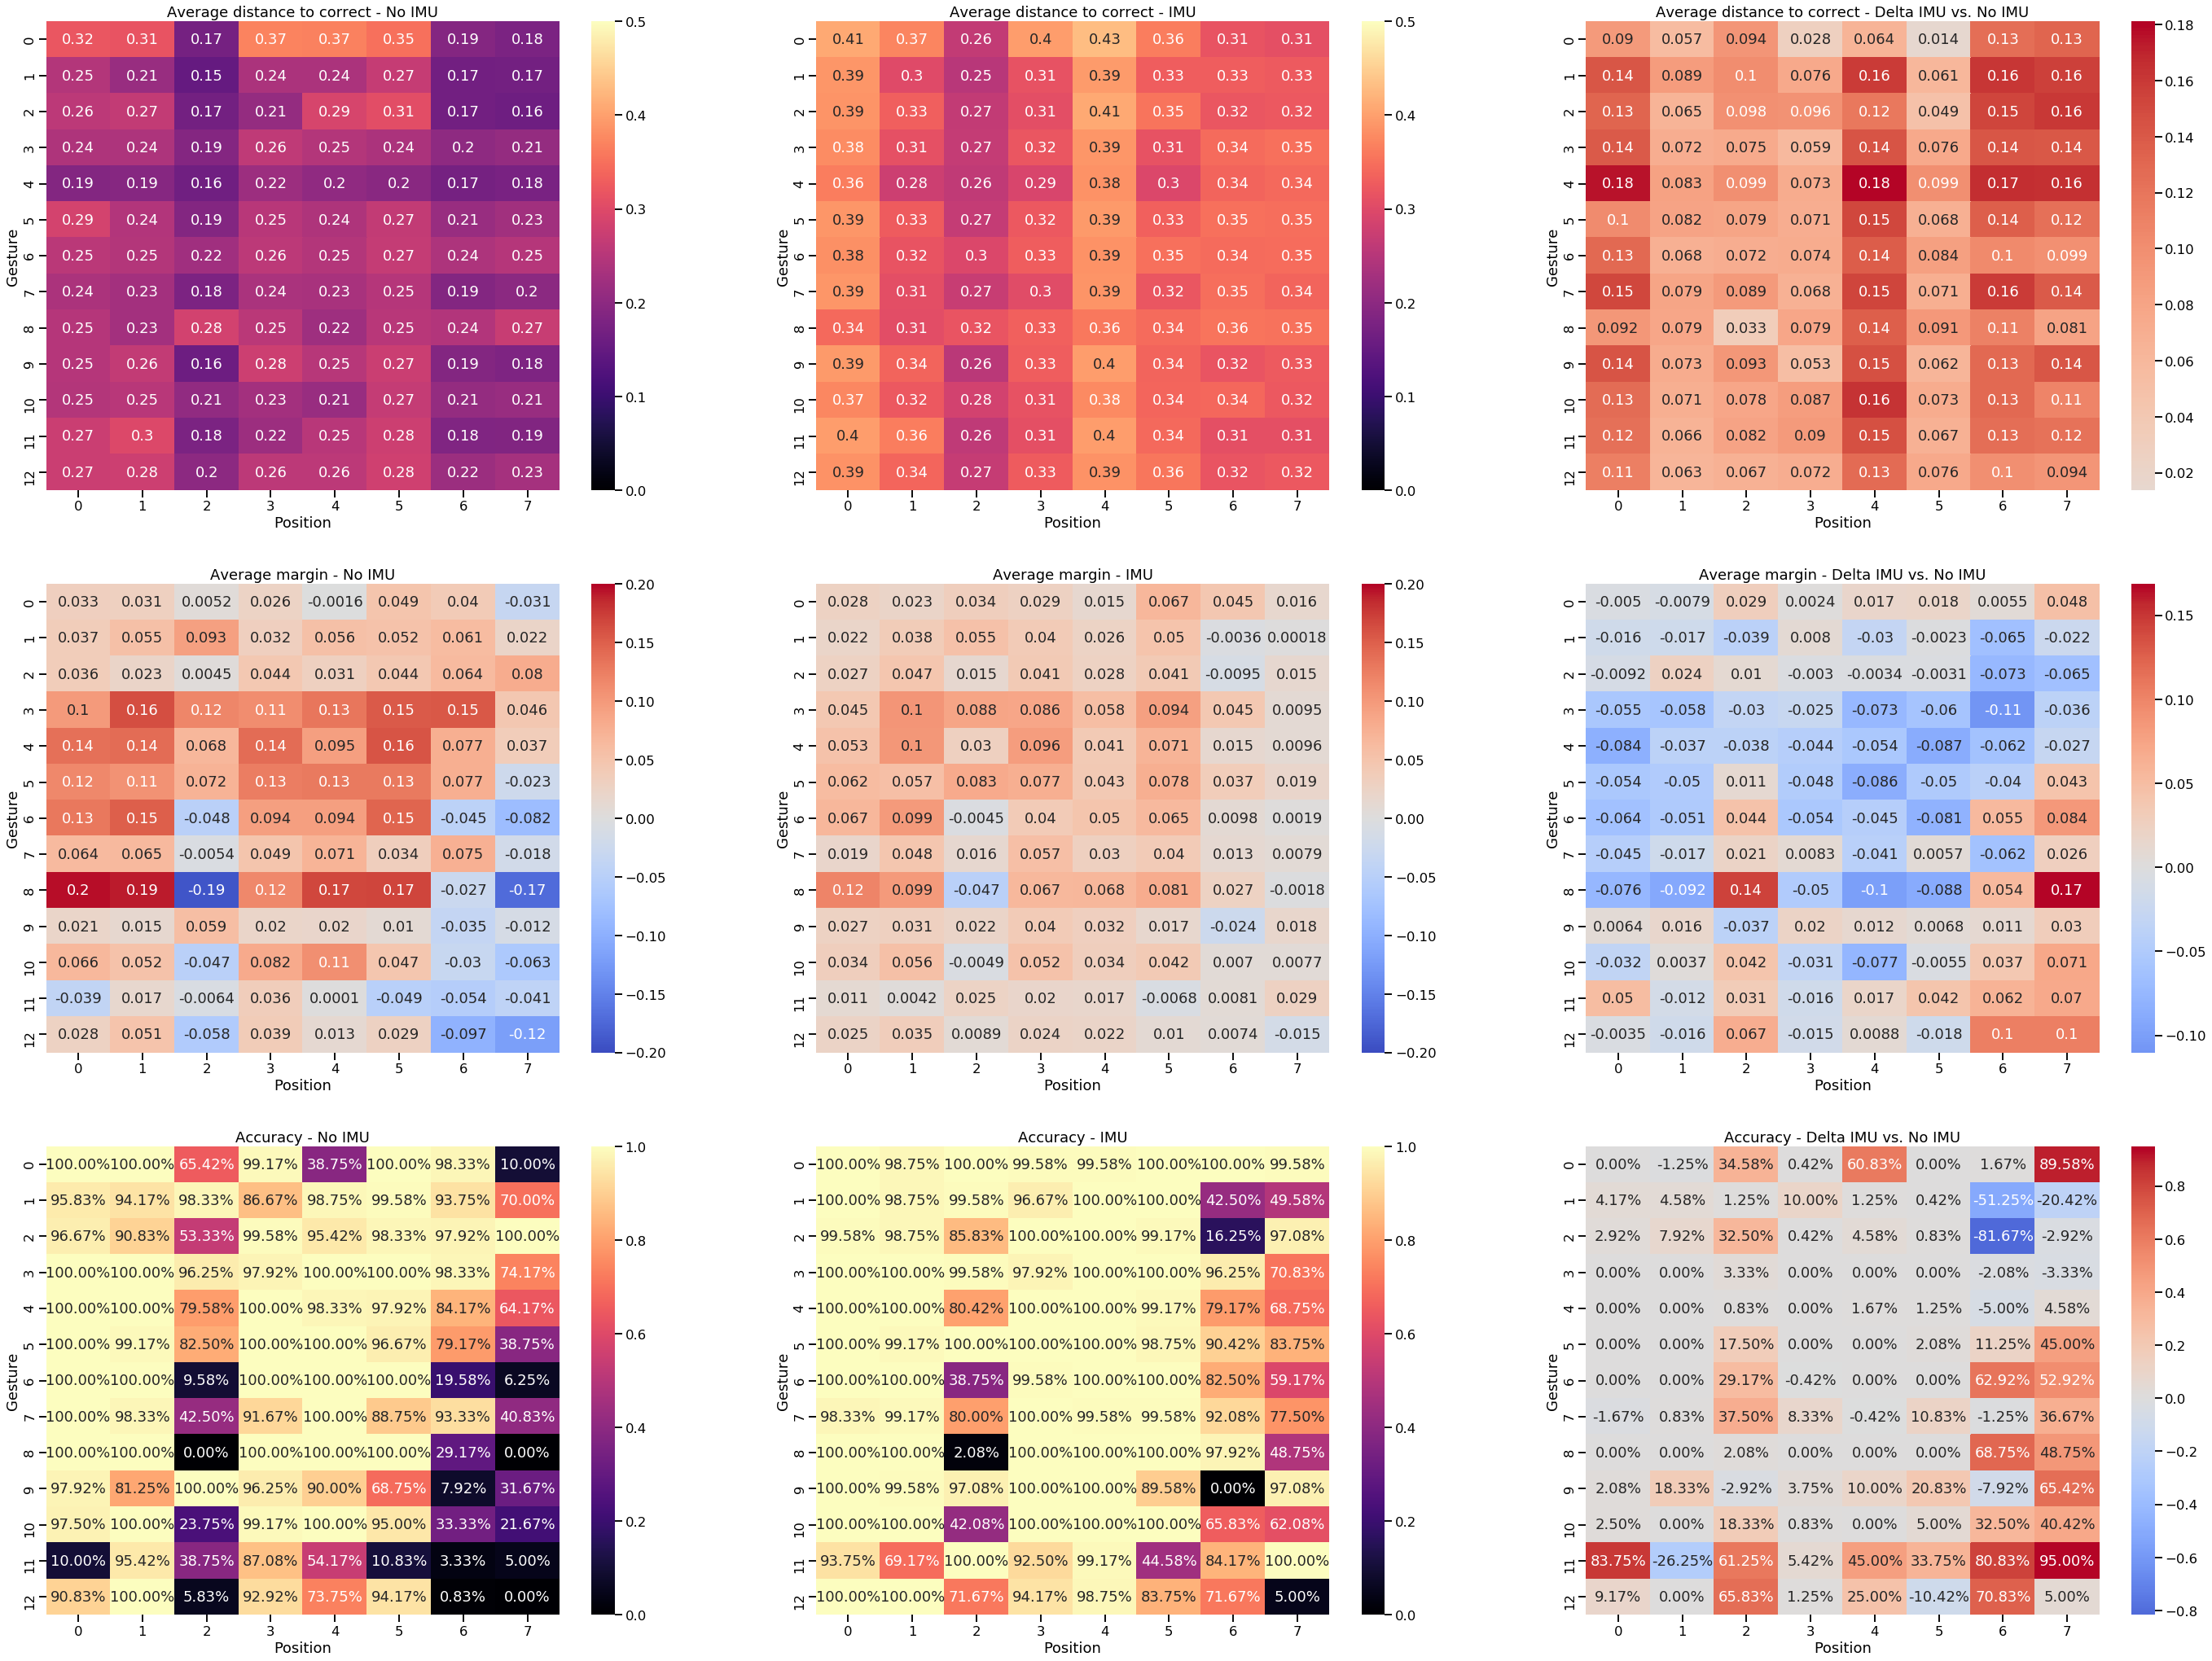

In [84]:
superCentroids = centroids(hv,label=gestLabel)[1]
superDists = cdist(hv,superCentroids,'hamming')

superCorrect = np.array([superDists[i,gestLabel[i]] for i in range(len(gestLabel))])
superIncorrect = np.array([np.min(np.delete(superDists[i],gestLabel[i])) for i in range(len(gestLabel))])
superMargin = (superIncorrect - superCorrect)/(superIncorrect + superCorrect)

superDistGP0 = np.zeros((numGestures,numPositions))
superMarginGP0 = np.zeros((numGestures,numPositions))
superCorrectGP0 = np.zeros((numGestures,numPositions))
for g in gestures:
    for p in positions:
        superDistGP0[g,p] = np.mean(superCorrect[(gestLabel == g) & (posLabel == p)])
        superMarginGP0[g,p] = np.mean(superMargin[(gestLabel == g) & (posLabel == p)])
        superCorrectGP0[g,p] = sum(superMargin[(gestLabel == g) & (posLabel == p)] > 0)/len(superMargin[(gestLabel == g) & (posLabel == p)])

superCentroids = centroids(hvAcc,label=gestLabel)[1]
superDists = cdist(hvAcc,superCentroids,'hamming')

superCorrect = np.array([superDists[i,gestLabel[i]] for i in range(len(gestLabel))])
superIncorrect = np.array([np.min(np.delete(superDists[i],gestLabel[i])) for i in range(len(gestLabel))])
superMargin = (superIncorrect - superCorrect)/(superIncorrect + superCorrect)

superDistGP = np.zeros((numGestures,numPositions))
superMarginGP = np.zeros((numGestures,numPositions))
superCorrectGP = np.zeros((numGestures,numPositions))
for g in gestures:
    for p in positions:
        superDistGP[g,p] = np.mean(superCorrect[(gestLabel == g) & (posLabel == p)])
        superMarginGP[g,p] = np.mean(superMargin[(gestLabel == g) & (posLabel == p)])
        superCorrectGP[g,p] = sum(superMargin[(gestLabel == g) & (posLabel == p)] > 0)/len(superMargin[(gestLabel == g) & (posLabel == p)])

f,ax = plt.subplots(3,3,figsize=(48,36))
ax = ax.flatten()   
        
sns.heatmap(superDistGP0,vmin=0,vmax=0.5,cmap='magma',annot=True,fmt='.2',ax=ax[0])
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Gesture')
ax[0].set_title('Average distance to correct - No IMU')
        
sns.heatmap(superDistGP,vmin=0,vmax=0.5,cmap='magma',annot=True,fmt='.2',ax=ax[1])
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Gesture')
ax[1].set_title('Average distance to correct - IMU')

sns.heatmap(superDistGP - superDistGP0,center=0,cmap='coolwarm',annot=True,fmt='.2',ax=ax[2])
ax[2].set_xlabel('Position')
ax[2].set_ylabel('Gesture')
ax[2].set_title('Average distance to correct - Delta IMU vs. No IMU')
        
sns.heatmap(superMarginGP0,vmin=-0.2,vmax=0.2,cmap='coolwarm',annot=True,fmt='.2',ax=ax[3])
ax[3].set_xlabel('Position')
ax[3].set_ylabel('Gesture')
ax[3].set_title('Average margin - No IMU')
        
sns.heatmap(superMarginGP,vmin=-0.2,vmax=0.2,cmap='coolwarm',annot=True,fmt='.2',ax=ax[4])
ax[4].set_xlabel('Position')
ax[4].set_ylabel('Gesture')
ax[4].set_title('Average margin - IMU')

sns.heatmap(superMarginGP - superMarginGP0,center=0,cmap='coolwarm',annot=True,fmt='.2',ax=ax[5])
ax[5].set_xlabel('Position')
ax[5].set_ylabel('Gesture')
ax[5].set_title('Average margin - Delta IMU vs. No IMU')

sns.heatmap(superCorrectGP0,annot=True,fmt='.2%',vmin=0,vmax=1,cmap='magma',ax=ax[6])
ax[6].set_xlabel('Position')
ax[6].set_ylabel('Gesture')
ax[6].set_title('Accuracy - No IMU')
        
sns.heatmap(superCorrectGP,annot=True,fmt='.2%',vmin=0,vmax=1,cmap='magma',ax=ax[7])
ax[7].set_xlabel('Position')
ax[7].set_ylabel('Gesture')
ax[7].set_title('Accuracy - IMU')

sns.heatmap(superCorrectGP - superCorrectGP0,annot=True,fmt='.2%',center=0,cmap='coolwarm',ax=ax[8])
ax[8].set_xlabel('Position')
ax[8].set_ylabel('Gesture')
ax[8].set_title('Accuracy - Delta IMU vs. No IMU')

plt.show()

In [225]:
sepCentroids = centroids(hv,label=groupGP)[1]
sepDists = cdist(hv,sepCentroids,'hamming')

sepCorrectMatch = np.array([sepDists[i][groupGP[i]] for i in range(len(groupGP))])
sepCorrectAll = np.array([sepDists[i][combGP[:,0] == combGP[groupGP[i]][0]] for i in range(len(groupGP))])
sepIncorrect = np.array([np.min(sepDists[i][combGP[:,0] != combGP[groupGP[i]][0]]) for i in range(len(groupGP))])
sepMarginMatch = (sepIncorrect - sepCorrectMatch)/(sepIncorrect + sepCorrectMatch)
sepMarginAll = (sepIncorrect.reshape(-1,1) - sepCorrectAll)/(sepIncorrect.reshape(-1,1) + sepCorrectAll)

sepDistMatchGP0 = np.zeros((numGestures,numPositions))
sepDistAllGP0 = np.zeros((numGestures,numPositions,numPositions))
sepMarginMatchGP0 = np.zeros((numGestures,numPositions))
sepMarginAllGP0 = np.zeros((numGestures,numPositions,numPositions))
sepCorrectMatchGP0 = np.zeros((numGestures,numPositions))
sepCorrectAllGP0 = np.zeros((numGestures,numPositions,numPositions))
for g in gestures:
    for p in positions:
        sepDistMatchGP0[g,p] = np.mean(sepCorrectMatch[(gestLabel == g) & (posLabel == p)])
        sepDistAllGP0[g,p,:] = np.mean(sepCorrectAll[(gestLabel == g) & (posLabel == p),:],axis=0)
        sepMarginMatchGP0[g,p] = np.mean(sepMarginMatch[(gestLabel == g) & (posLabel == p)])
        sepMarginAllGP0[g,p,:] = np.mean(sepMarginAll[(gestLabel == g) & (posLabel == p),:],axis=0)
        sepCorrectMatchGP0[g,p] = sum(sepMarginMatch[(gestLabel == g) & (posLabel == p)] > 0)/len(sepMarginMatch[(gestLabel == g) & (posLabel == p)])
        sepCorrectAllGP0[g,p,:] = np.sum(sepMarginAll[(gestLabel == g) & (posLabel == p)] > 0,axis=0)/len(sepMarginMatch[(gestLabel == g) & (posLabel == p)])
        
sepCentroids = centroids(hvAcc,label=groupGP)[1]
sepDists = cdist(hvAcc,sepCentroids,'hamming')

sepCorrectMatch = np.array([sepDists[i][groupGP[i]] for i in range(len(groupGP))])
sepCorrectAll = np.array([sepDists[i][combGP[:,0] == combGP[groupGP[i]][0]] for i in range(len(groupGP))])
sepIncorrect = np.array([np.min(sepDists[i][combGP[:,0] != combGP[groupGP[i]][0]]) for i in range(len(groupGP))])
sepMarginMatch = (sepIncorrect - sepCorrectMatch)/(sepIncorrect + sepCorrectMatch)
sepMarginAll = (sepIncorrect.reshape(-1,1) - sepCorrectAll)/(sepIncorrect.reshape(-1,1) + sepCorrectAll)

sepDistMatchGP = np.zeros((numGestures,numPositions))
sepDistAllGP = np.zeros((numGestures,numPositions,numPositions))
sepMarginMatchGP = np.zeros((numGestures,numPositions))
sepMarginAllGP = np.zeros((numGestures,numPositions,numPositions))
sepCorrectMatchGP = np.zeros((numGestures,numPositions))
sepCorrectAllGP = np.zeros((numGestures,numPositions,numPositions))
for g in gestures:
    for p in positions:
        sepDistMatchGP[g,p] = np.mean(sepCorrectMatch[(gestLabel == g) & (posLabel == p)])
        sepDistAllGP[g,p,:] = np.mean(sepCorrectAll[(gestLabel == g) & (posLabel == p),:],axis=0)
        sepMarginMatchGP[g,p] = np.mean(sepMarginMatch[(gestLabel == g) & (posLabel == p)])
        sepMarginAllGP[g,p,:] = np.mean(sepMarginAll[(gestLabel == g) & (posLabel == p),:],axis=0)
        sepCorrectMatchGP[g,p] = sum(sepMarginMatch[(gestLabel == g) & (posLabel == p)] > 0)/len(sepMarginMatch[(gestLabel == g) & (posLabel == p)])
        sepCorrectAllGP[g,p,:] = np.sum(sepMarginAll[(gestLabel == g) & (posLabel == p)] > 0,axis=0)/len(sepMarginMatch[(gestLabel == g) & (posLabel == p)])

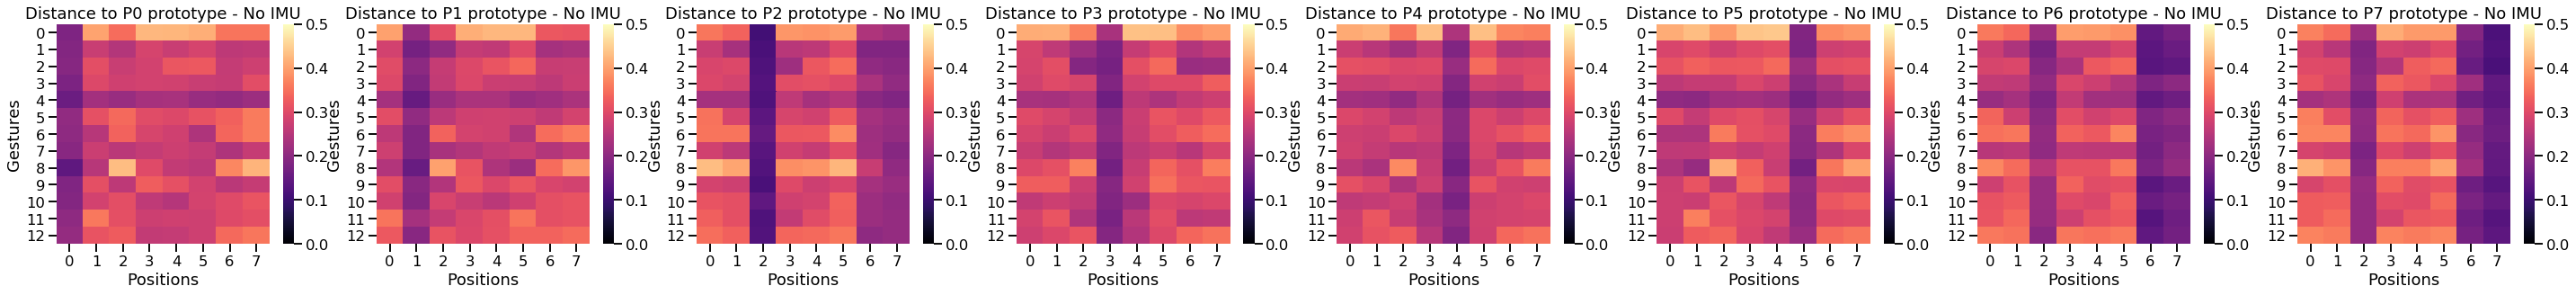

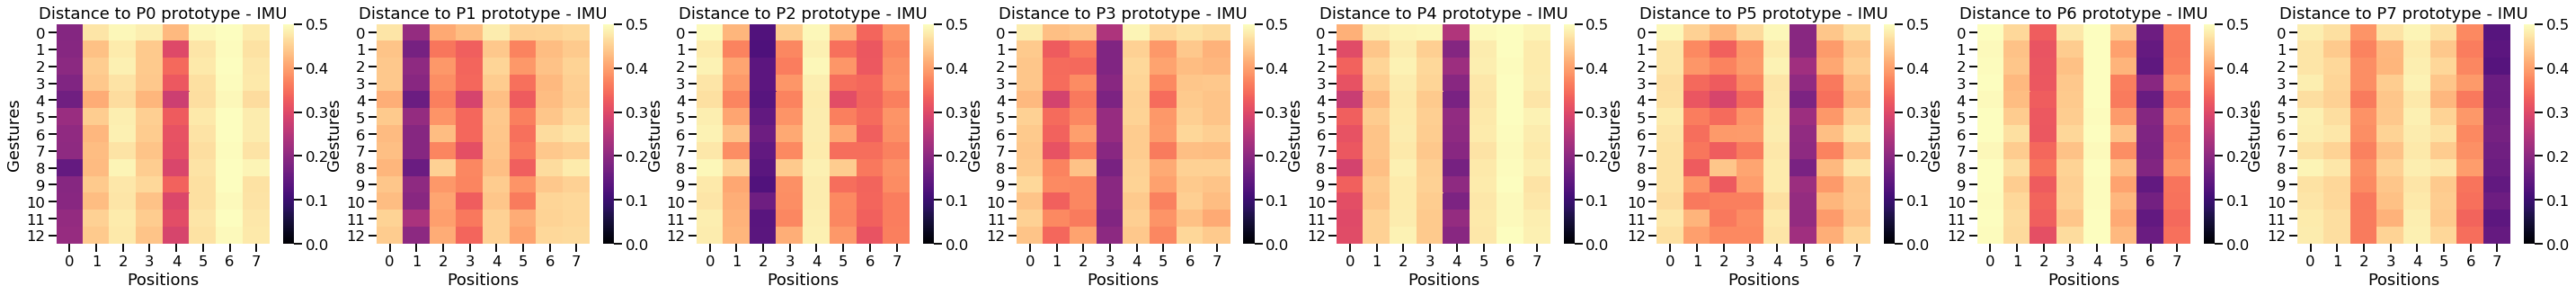

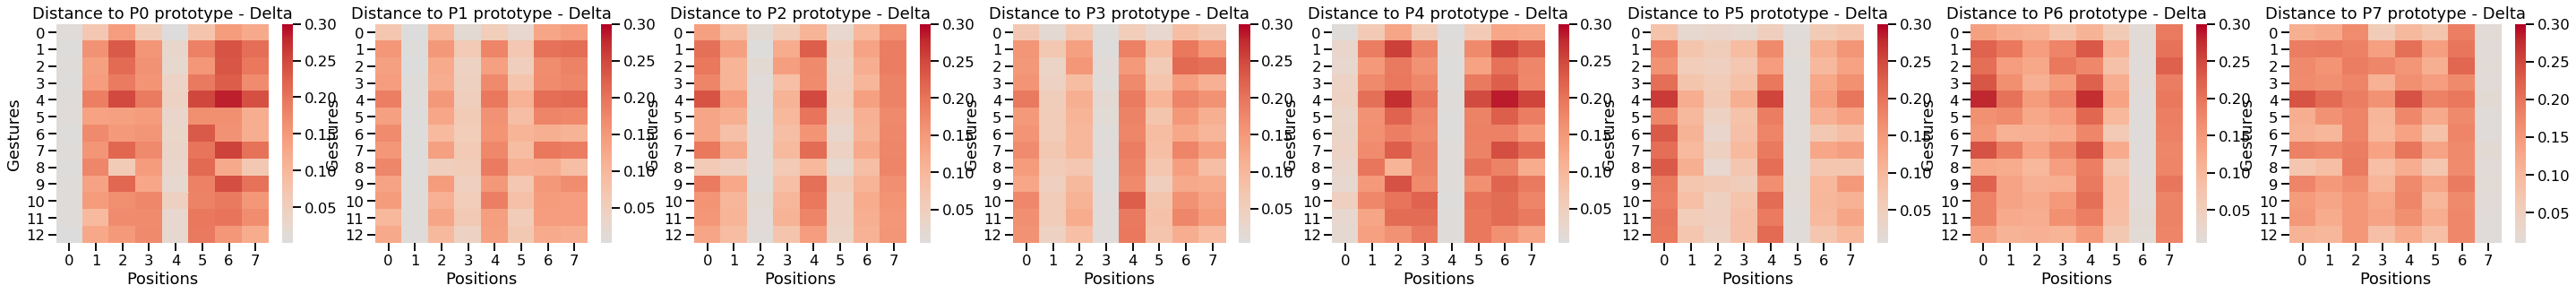

In [240]:
f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepDistAllGP0[:,:,i],vmin=0,vmax=0.5,cmap='magma',ax=ax[i])
    ax[i].set_title('Distance to P%d prototype - No IMU' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()

f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepDistAllGP[:,:,i],vmin=0,vmax=0.5,cmap='magma',ax=ax[i])
    ax[i].set_title('Distance to P%d prototype - IMU' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()

f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepDistAllGP[:,:,i]-sepDistAllGP0[:,:,i],center=0,vmax=0.3,cmap='coolwarm',ax=ax[i])
    ax[i].set_title('Distance to P%d prototype - Delta' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()

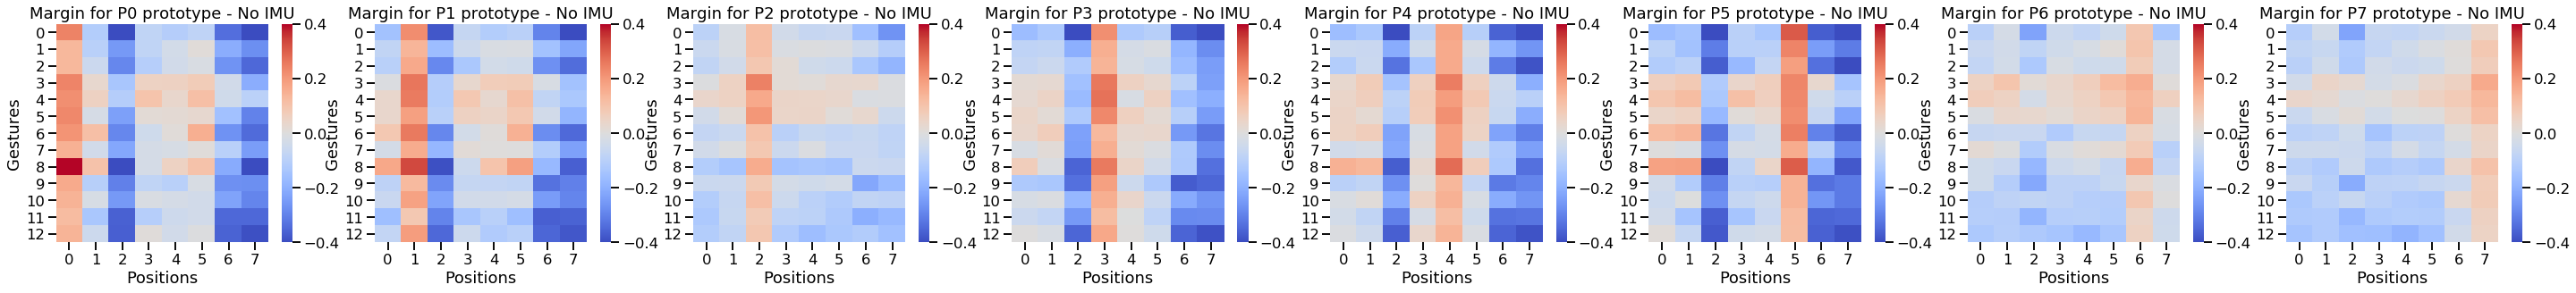

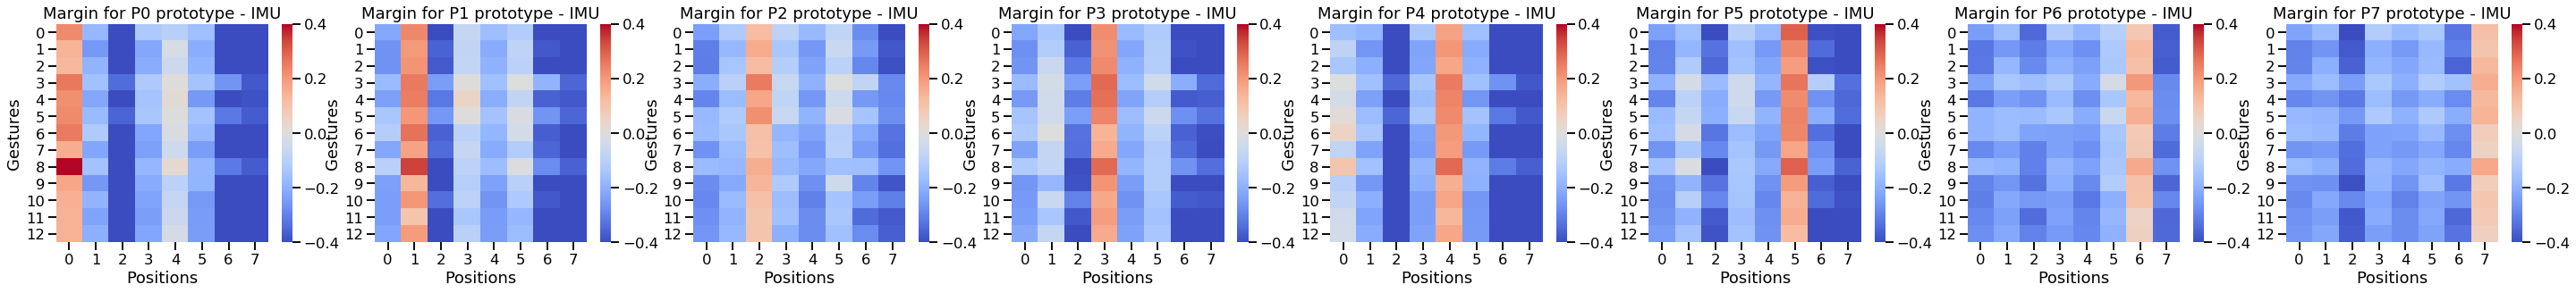

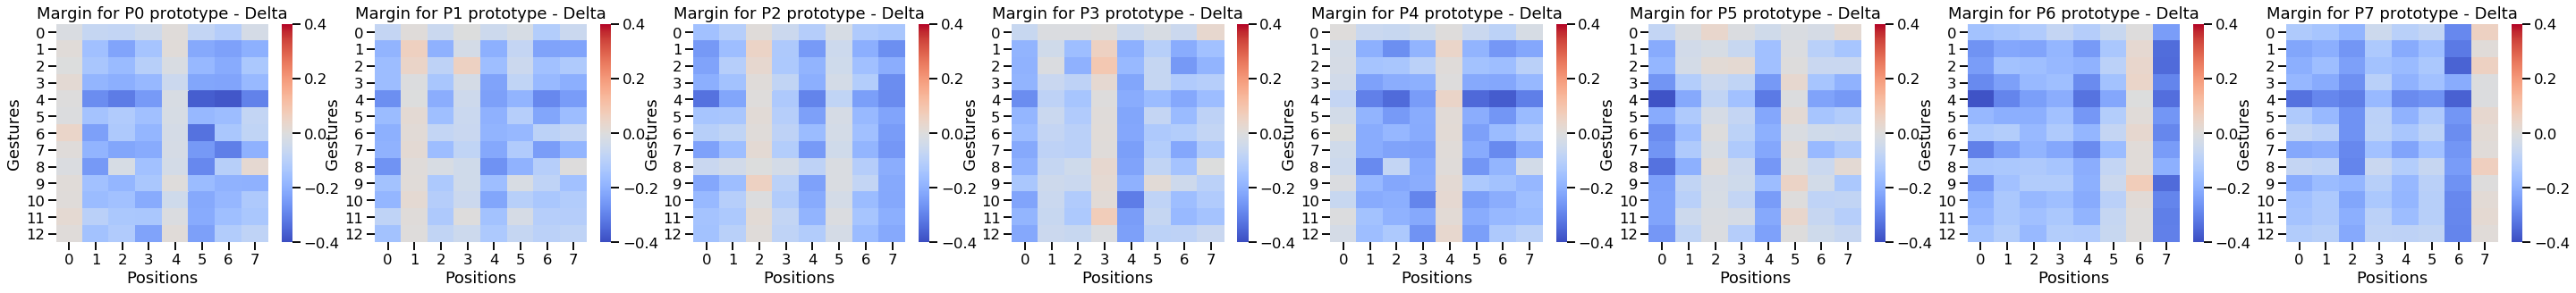

In [241]:
f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepMarginAllGP0[:,:,i],cmap='coolwarm',vmin=-0.4,vmax=0.4,ax=ax[i])
    ax[i].set_title('Margin for P%d prototype - No IMU' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()

f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepMarginAllGP[:,:,i],cmap='coolwarm',vmin=-0.4,vmax=0.4,ax=ax[i])
    ax[i].set_title('Margin for P%d prototype - IMU' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()

f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepMarginAllGP[:,:,i]-sepMarginAllGP0[:,:,i],vmin=-0.4,vmax=0.4,cmap='coolwarm',ax=ax[i])
    ax[i].set_title('Margin for P%d prototype - Delta' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()

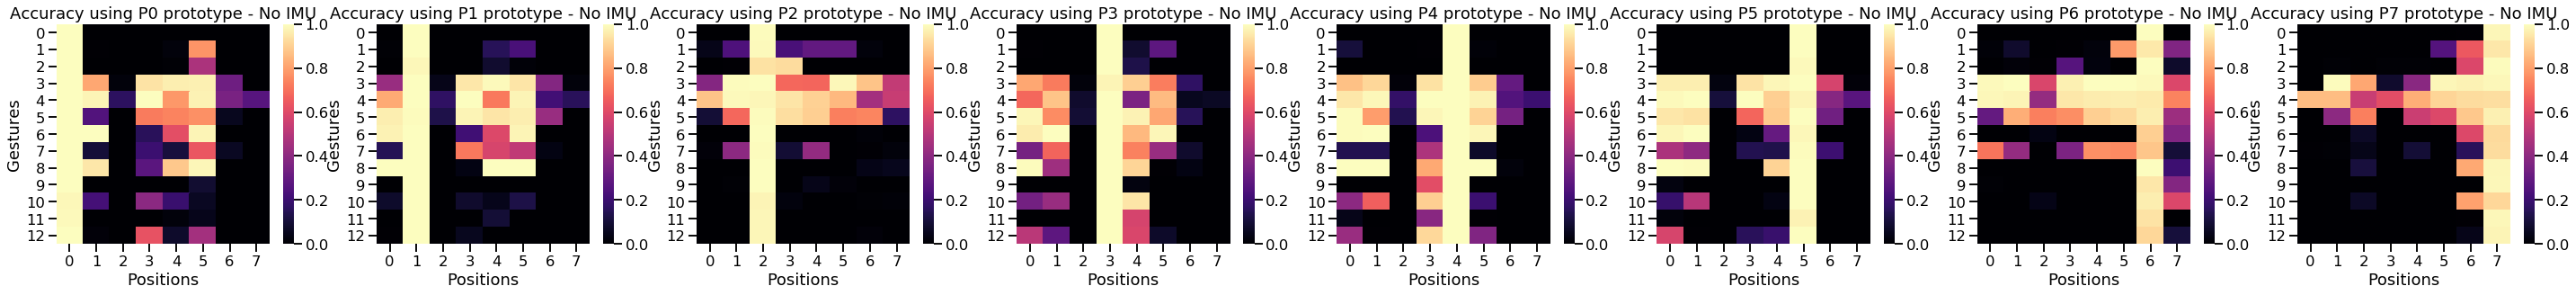

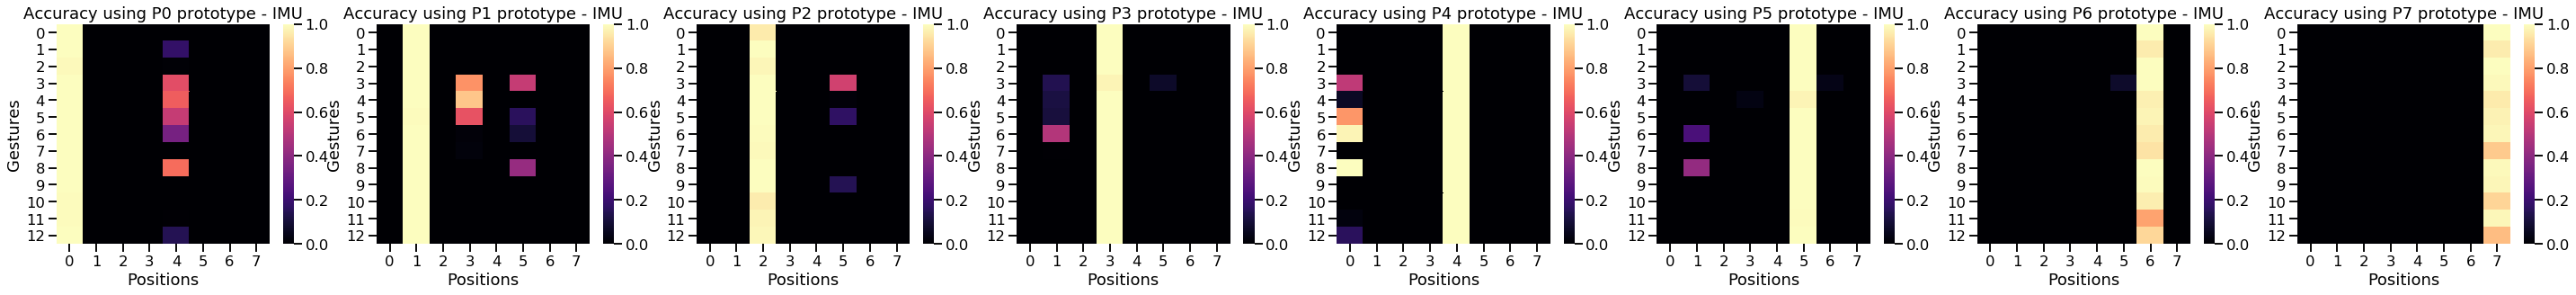

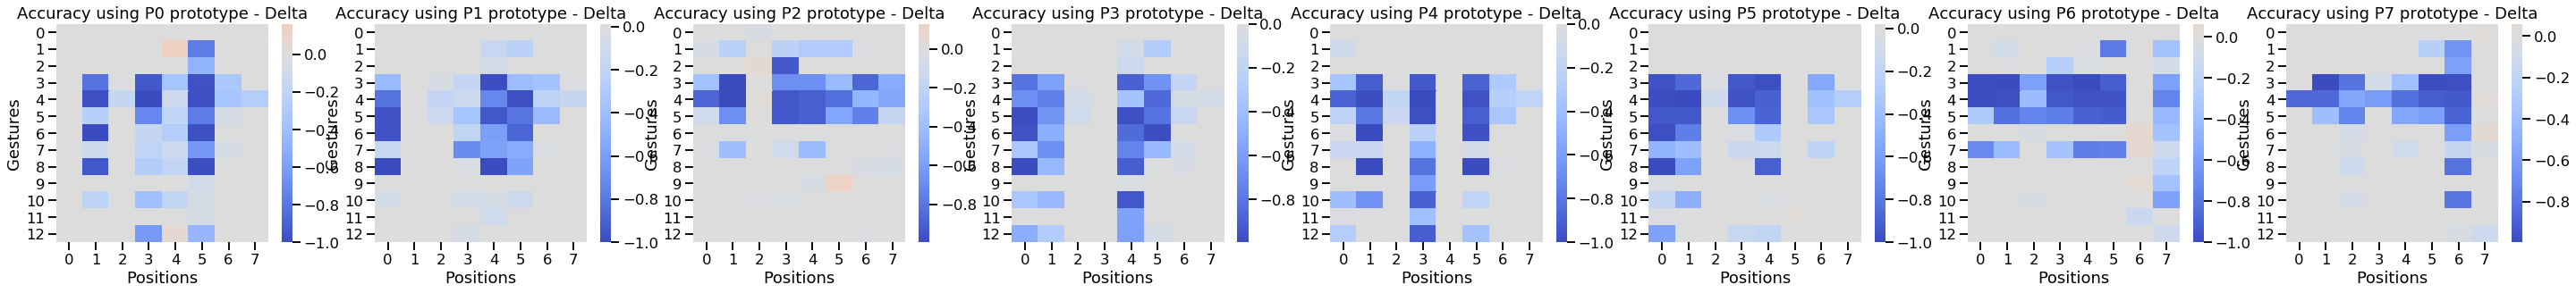

In [245]:
f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepCorrectAllGP0[:,:,i],vmin=0,vmax=1,cmap='magma',ax=ax[i])
    ax[i].set_title('Accuracy using P%d prototype - No IMU' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()

f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepCorrectAllGP[:,:,i],vmin=0,vmax=1,cmap='magma',ax=ax[i])
    ax[i].set_title('Accuracy using P%d prototype - IMU' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()

f,ax = plt.subplots(1,numPositions,figsize=(50,4.5))
for i in range(numPositions):
    sns.heatmap(sepCorrectAllGP[:,:,i]-sepCorrectAllGP0[:,:,i],center=0,cmap='coolwarm',ax=ax[i])
    ax[i].set_title('Accuracy using P%d prototype - Delta' % i)
    ax[i].set_xlabel('Positions')
    ax[i].set_ylabel('Gestures')
plt.show()